In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import os
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.patch_baseline import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification

2023-11-22 19:18:19.116964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 19:18:22.281622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
torch.autograd.set_grad_enabled(False)

## Model Arguments

In [11]:
args = {
    'model_type': 'bert', # bert, medical_bert, pubmed_bert, biobert, clinical_biobert
    'task': 'path',
    'field': 'PrimaryGleason'
}

device = 'cuda:0'

In [12]:
if args['model_type'] == 'bert':
    bert_path = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
elif args['model_type'] == 'medical_bert':
    bert_path = f"{base_dir}/models/pretrained/bert_pretrain_output_all_notes_150000/"
    tokenizer = BertTokenizer.from_pretrained(bert_path, local_files_only=True)
elif args['model_type'] == 'pubmed_bert':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
elif args['model_type'] == 'pubmed_bert_full':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
elif args['model_type'] == 'biobert':
    bert_path = "dmis-lab/biobert-v1.1"
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
elif args['model_type'] == 'clinical_biobert':
    bert_path = "emilyalsentzer/Bio_ClinicalBERT"
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

## Load Data

you can cutomize the code here to read in your own data.

In [13]:
# Read in data
#field = 'PrimaryGleason' # out of PrimaryGleason, SecondaryGleason', 'MarginStatusNone', 'SeminalVesicleNone'
path = f"../data/prostate.json"
data = readJson(path)

# Clean reports
data = cleanSplit(data, stripChars)
data['dev_test'] = cleanReports(data['dev_test'], stripChars)
data = fixLabel(data)

train_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['train']]
val_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['val']]
test_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['test']]
print(len(train_documents), len(val_documents),len(test_documents))

Token indices sequence length is longer than the specified maximum sequence length for this model (1345 > 512). Running this sequence through the model will result in indexing errors


2066 517 324


In [14]:
# Create datasets
train_labels = [patient['labels'][args['field']] for patient in data['train']]
val_labels = [patient['labels'][args['field']] for patient in data['val']]
test_labels = [patient['labels'][args['field']] for patient in data['test']]

train_documents, train_labels = exclude_labels(train_documents, train_labels)
val_documents, val_labels = exclude_labels(val_documents, val_labels)
test_documents, test_labels = exclude_labels(test_documents, test_labels)

le = preprocessing.LabelEncoder()
le.fit(train_labels)

# Map raw label to processed label
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
le_dict = {str(key):le_dict[key] for key in le_dict}

for label in val_labels + test_labels:
    if str(label) not in le_dict:
        le_dict[str(label)] = len(le_dict)

# Map processed label back to raw label
inv_le_dict = {v: k for k, v in le_dict.items()}

In [15]:
documents_full = train_documents + val_documents + test_documents
labels_full = train_labels + val_labels + test_labels

## Load Trained Models

In [17]:
#load finetuned model
model_path = f"{base_dir}/models/{args['task']}/{args['model_type']}_{args['field']}"
checkpoint_file = f"{model_path}/save_output"
config_file = f"{model_path}/save_output/config.json"

model = BertForSequenceClassification.from_pretrained(checkpoint_file, num_labels=len(le_dict), output_hidden_states=True)

model = model.eval()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Path Patching Code

In [18]:
label_idx_4_5 = [] #934
label_idx_4 = [] #855
label_idx_5 = [] #79
label_idx_3 = [] #1934

for i, x in enumerate(labels_full):
    if x == '4':
        label_idx_4_5.append(i)
        label_idx_4.append(i)
    elif x == '5':
        label_idx_4_5.append(i)
        label_idx_5.append(i)
    elif x == '3':
        label_idx_3.append(i)

# Collect mean head response

In [31]:
with torch.no_grad():
    NUM_SAMPLES = 500
    index_lst = random.sample(label_idx_4, NUM_SAMPLES)
    docs = [documents_full[i] for i in index_lst]
    
    rel_collect = []
    irrel_collect = []
    for doc in tqdm.tqdm(docs):
        encoding = get_encoding(doc, tokenizer, device)
        _, _, _, context_dict = prop_classifier_model_patched_baseline(encoding, model, output_context=True)
        rel_context = np.stack(context_dict['rel'])
        irrel_context = np.stack(context_dict['irrel'])
        
        rel_collect.append(rel_context.squeeze(1)) #(12, 512, 12, 64)
        irrel_collect.append(irrel_context.squeeze(1))
    rel_collect = np.stack(rel_collect)
    irrel_collect = np.stack(irrel_collect)

100%|██████████| 500/500 [01:49<00:00,  4.56it/s]


In [32]:
mean_act = np.mean(irrel_collect, axis=0)

In [18]:
import pickle

path = f"{base_dir}/output/{args['task']}/{args['model_type']}_{args['field']}/h_to_logits"
os.makedirs(path, exist_ok=True)

#with open(os.path.join(path, f"mean_head_out_res_label4_500.pkl"), 'wb') as handle:
#    pickle.dump(mean_act, handle)
    
with open(os.path.join(path, f"mean_head_out_res_label4_500.pkl"), 'rb') as handle:
    back = pickle.load(handle)

## h to logits - ablate with mean responses

In [43]:
def patch_h_to_logits_at_pos_baseline(encoding, model, pos, label_idx, mean_act):
    # patch one node at a time
    raw_logit = model(**encoding)[0][0][label_idx] # == raw_irrel
    h_ctbn_lst = []
    for level in range(12):
        h_ctbn_lst.append([])
        for h in range(12):
            patched_entry = [(level, pos, h)]
            _, irrel, _, _ = prop_classifier_model_patched_baseline(encoding, model, patched_entry, mean_act)
            ablated_act = irrel[0][label_idx] # head ctbn
            logit_diff = ablated_act - raw_logit
            print(ablated_act)
            print(raw_logit)
            print(logit_diff)
            break
            h_ctbn_lst[level].append(logit_diff / abs(raw_logit) * 100)

        h_ctbn_lst[level] = torch.stack(h_ctbn_lst[level])
    h_ctbn_tot = torch.stack(h_ctbn_lst).cpu().numpy()
    return h_ctbn_tot

In [46]:
with open(os.path.join(path, f"mean_head_out_res_500.pkl"), 'rb') as handle:
    back = pickle.load(handle)

In [47]:
doc = documents_full[0]
label = labels_full[0]

encoding = get_encoding(doc, tokenizer, device)
label_idx = le_dict[label]

In [48]:
model(**encoding)[0][0][label_idx]

tensor(6.1641, device='cuda:0')

In [49]:
rel, irrel, _, _ = prop_classifier_model_patched_baseline(encoding, model, [(0, 0, 0)], back)

In [50]:
rel[0][label_idx], irrel[0][label_idx]

(tensor(0., device='cuda:0'), tensor(6.1642, device='cuda:0'))

In [36]:
# using the CD system:

with torch.no_grad():
    NUM_SAMPLES = 200
    POS = 0
    index_lst = random.sample(label_idx_3, NUM_SAMPLES)
    docs = [documents_full[i] for i in index_lst]
    labels = [labels_full[i] for i in index_lst]

    h_ctbn = []
    for doc, label in tqdm.tqdm(zip(docs, labels)):
        encoding = get_encoding(doc, tokenizer, device)
        label_idx = le_dict[label]
        h_ctbn_tot = patch_h_to_logits_at_pos_baseline(encoding, model, POS, label_idx, back)
        h_ctbn.append(h_ctbn_tot) #[12, 12] = [Layer, HEAD]

    h_ctbn = np.stack(h_ctbn)

200it [44:11, 13.26s/it]


In [37]:
avg_h_ctbn = np.mean(h_ctbn, axis=0)

In [29]:
import pickle

path = f"{base_dir}/output/{args['task']}/{args['model_type']}_{args['field']}/h_to_logits"
os.makedirs(path, exist_ok=True)

#with open(os.path.join(path, f"singleH_{NUM_SAMPLES}_baseline_out_res_label3.pkl"), 'wb') as handle:
#    pickle.dump(avg_h_ctbn, handle)
    
with open(os.path.join(path, f"singleH_200_baseline_out_res.pkl"), 'rb') as handle:
    back = pickle.load(handle)

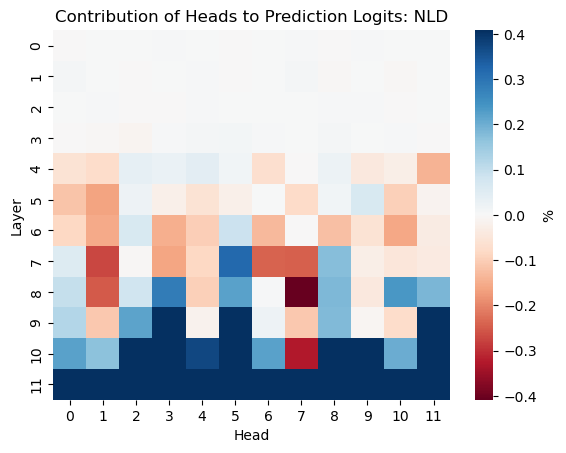

In [38]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

cm_max = max(avg_h_ctbn.flatten())
cm_min = -cm_max

s = sns.heatmap(-avg_h_ctbn, xticklabels = range(12), yticklabels = range(12), cmap='RdBu', cbar_kws={'label': '%'},
               vmin=cm_min, vmax=cm_max)
s.set(xlabel='Head', ylabel='Layer')
plt.title(f"Contribution of Heads to Prediction Logits: NLD")
plt.show()

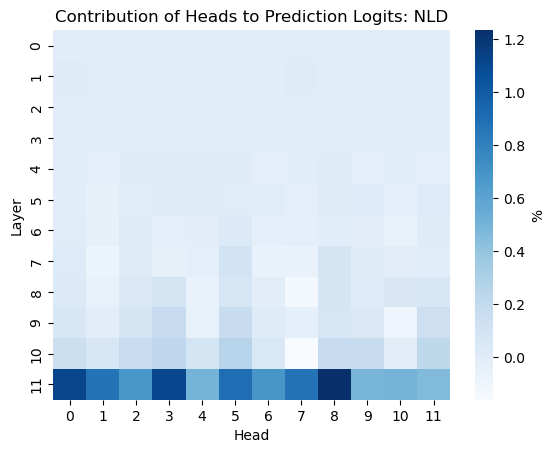

In [30]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#std_h_ctbn = np.std(h_ctbn, axis=0)

s = sns.heatmap(-back, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': '%'})
s.set(xlabel='Head', ylabel='Layer')
plt.title(f"Contribution of Heads to Prediction Logits: NLD")
plt.show()

In [53]:
# take 5 most positives and 5 most negatives
a = -back
top5_idxs = np.argsort(a.ravel())[-1:]
rows, cols = top5_idxs//12, top5_idxs%12
positives = []
for r, c in zip(rows, cols):
    positives.append((r, c))
print(positives)

[(11, 8)]


In [54]:
def collect_attended_tokens(positives_heads, N=100, Z_thres=2, POS=0):
    index_lst = random.sample(range(0, len(documents_full)), N)
    docs = [documents_full[i] for i in index_lst]
    
    collect = collections.defaultdict(int)
    for doc in docs:
        encoding = get_encoding(doc, tokenizer, device) #1120
        raw_rel, raw_irrel, raw_att_probs_lst, _ = prop_classifier_model_patched_baseline(encoding, model, [], output_att_prob=True)
        raw_att_probs = torch.stack(raw_att_probs_lst).cpu().numpy()

        avg_att_m = np.zeros((512))
        for level, h in positives:
            att_m = raw_att_probs[level, h, POS, :]
            avg_att_m += att_m

        avg_att_m /= len(positives)
        
        # convert to word level
        interval_dict, word_lst = compute_word_intervals(encoding)
        word_att_m = combine_token_attn(interval_dict, avg_att_m)
        
        Z = (word_att_m - np.mean(word_att_m)) / np.std(word_att_m)

        positive_words = np.where(Z > Z_thres)
        
        for w_idx in positive_words[0]:
            w = word_lst[w_idx]
            #collect[w] += 1
            collect[w] += word_att_m[w_idx]
            
    return collect

In [55]:
def combine_token_attn(interval_dict, avg_att_m):
    word_cnt = len(interval_dict)
    new_att_m = np.zeros(word_cnt)
    for i in range(word_cnt):
        t_idx_lst = interval_dict[i+1]
        if len(t_idx_lst) == 1:
            new_att_m[i] = avg_att_m[t_idx_lst[0]]
        else:
            new_att_m[i] = np.sum(avg_att_m[t_idx_lst[0]:t_idx_lst[-1]+1])
    return new_att_m

In [56]:
def compute_word_intervals(encoding):
    word_cnt = 0
    interval_dict = collections.defaultdict(list)
    
    pretok_sent = ""
    for i in range(512):
        tok = tokenizer.decode(encoding['input_ids'][:, i])
        if tok.startswith("##"):
            interval_dict[word_cnt].append(i)
            pretok_sent += tok[2:]
        else:
            word_cnt += 1
            interval_dict[word_cnt].append(i)
            pretok_sent += " " + tok
    pretok_sent = pretok_sent[1:]
    word_lst = pretok_sent.split(" ")
    
    assert(len(interval_dict) == len(word_lst))
    
    return interval_dict, word_lst

In [57]:
positive_attended_token_freq = collect_attended_tokens(positives, N=500, Z_thres=3)
positive_attended_token_freq = sorted(positive_attended_token_freq.items(), key=lambda k_v: k_v[1], reverse=True)

In [58]:
import json
with open('result_baseline_top1.json', 'w') as fp:
    json.dump(positive_attended_token_freq, fp)

In [ ]:
# look at the identified head attention pattern
# extract groups

# Auto-extract attention head groups

In [325]:
def get_candidates(g, global_c, LAYER, HEADS, POS):
    #all_heads = list(itertools.product(range(LAYER), range(HEADS)))
    #candidate_heads = set(all_heads) - set(g)
    
    pos_L, pos_R, layer_up, layer_down = get_curr_LR(g)
    
    new_pos_L = pos_L - 1 if pos_L > 0 else pos_L
    new_pos_R = pos_R + 1 if pos_R < HEADS - 1 else pos_R
    new_layer_up = layer_up - 1 if layer_up > 0 else layer_up
    new_layer_down = layer_down + 1 if layer_down < LAYER - 1 else layer_down
    
    local_heads = list(itertools.product(range(new_layer_up, new_layer_down+1), range(new_pos_L, new_pos_R+1)))
    local_heads = [(l, POS, h) for (l, h) in local_heads]
    candidate_heads = list(set(local_heads) - set(g).intersection(set(local_heads)))

    candidate_groups = []
    for c in candidate_heads:
        new_g = g.copy()
        new_g.append(c)
        if frozenset(new_g) not in global_c:
            candidate_groups.append(new_g)
            global_c.add(frozenset(new_g))
    
    return candidate_groups, global_c
    
    
def get_curr_LR(g):
    pos_L, pos_R, layer_up, layer_down = np.float('inf'), np.float('-inf'), np.float('inf'), np.float('-inf')
    for item in g:
        pos_L = min(pos_L, item[-1])
        pos_R = max(pos_R, item[-1])
        layer_up = min(layer_up, item[0])
        layer_down = max(layer_down, item[0])
    return pos_L, pos_R, layer_up, layer_down

def compute_score(patched_entry, model, doc, label, le_dict):
    encoding = get_encoding(doc, tokenizer, device)
    label_idx = le_dict[label]
    raw_logit = model(**encoding)[0][0][label_idx]
    rel, _, _, _ = prop_classifier_model_patched(encoding, model, patched_entry)
    rel = rel[0][label_idx] # head ctbn
    return rel / abs(raw_logit) * 100

In [341]:
import itertools
import heapq
from heapq import heappush, heappop
from collections import defaultdict

with torch.no_grad():
    NUM_SAMPLES = 1
    POS = 0
    index_lst = random.sample(range(0, len(documents_full)), NUM_SAMPLES)
    print(index_lst[0])
    docs = [documents_full[i] for i in index_lst]
    labels = [labels_full[i] for i in index_lst]
    doc, label = docs[0], labels[0]
    
    LAYER = 12
    HEADS = 12
    
    ITER = 5 #20mins
    TOP_K = 0.3

    heap = []
    tree = defaultdict()
    global_c = set()

    # initialize with single head effects
    for i in range(LAYER*HEADS):
        l_idx = i//LAYER
        h_idx = i%LAYER
        heappush(heap, (-back[l_idx, h_idx], [(l_idx, POS, h_idx)], ['base'])) #[-score, curr_group, parent]
        global_c.add(frozenset([(l_idx, POS, h_idx)]))
        
    level = 0
    for _ in tqdm.tqdm(range(ITER)):
        #selected_gs = heapq.nsmallest(int(TOP_K*len(heap)), heap)
        selected_gs = []
        for _ in range(int(TOP_K*len(heap))):
            selected_gs.append(heappop(heap))
        #print(selected_gs)
        tree[level] = selected_gs
        #heap = []

        for selected_g in selected_gs:
            selected_score, selected_g = -selected_g[0], selected_g[1]
            candidate_gs, global_c = get_candidates(selected_g, global_c, LAYER, HEADS, POS)
            for candidate_g in candidate_gs:
                candidate_score = compute_score(candidate_g, model, doc, label, le_dict).detach().cpu().numpy()
                if candidate_score > selected_score:
                    heappush(heap, (-candidate_score, candidate_g, selected_g))
        level += 1

1750


100%|██████████| 5/5 [53:27<00:00, 641.58s/it] 


In [342]:
path = f"{base_dir}/output/{args['task']}/{args['model_type']}_{args['field']}/h_to_logits"
os.makedirs(path, exist_ok=True)

with open(os.path.join(path, f"agg_tree_{index_lst[0]}.pkl"), 'wb') as handle:
    pickle.dump(tree, handle)
    
with open(os.path.join(path, f"agg_tree_{index_lst[0]}.pkl"), 'rb') as handle:
    copy_tree = pickle.load(handle)

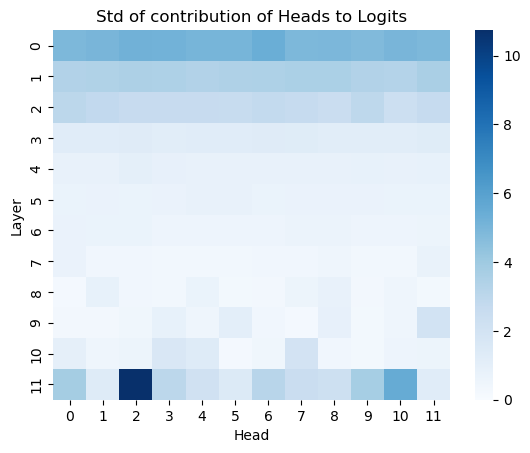

In [589]:
# plot std of h -> logits effect

cm_max = max(std_h_ctbn.flatten())
cm_min = 0.00

s = sns.heatmap(std_h_ctbn, xticklabels = range(12), yticklabels = range(12), cmap='Blues', vmin=cm_min, vmax=cm_max, cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
plt.title("Std of contribution of Heads to Logits")
plt.show()

In [804]:
expand_avg = np.repeat(avg_h_ctbn[np.newaxis, :, :], NUM_SAMPLES, axis=0)
expand_std = np.repeat(std_h_ctbn[np.newaxis, :, :], NUM_SAMPLES, axis=0)
assert(np.repeat(avg_h_ctbn[np.newaxis, :, :], NUM_SAMPLES, axis=0)[0].all() == np.repeat(avg_h_ctbn[np.newaxis, :, :], NUM_SAMPLES, axis=0)[1].all())

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_132017/34418999.py:3 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_132017/34418999.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 1 is out of bounds for axis 0 with size 1

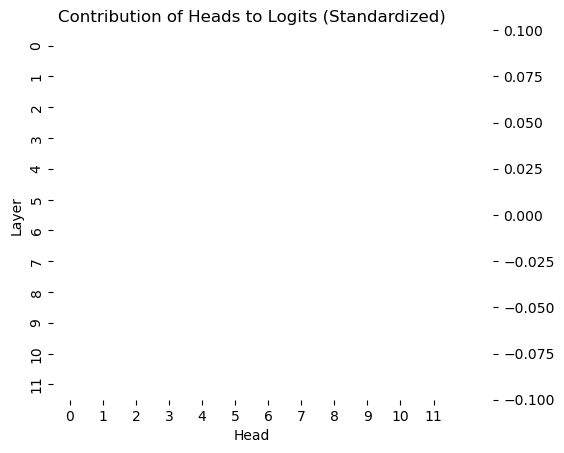

In [805]:
standardized = (h_ctbn - expand_avg) / expand_std
avg_standardized = np.mean(standardized, axis=0)
cm_max = max(avg_standardized.flatten())
cm_min = -cm_max


s = sns.heatmap(avg_standardized, xticklabels = range(12), yticklabels = range(12), cmap='RdBu', vmin=cm_min, vmax=cm_max, cbar_kws={'label': ''}, center=0.00)
s.set(xlabel='Head', ylabel='Layer')
plt.title("Contribution of Heads to Logits (Standardized)")
plt.show()

# Inspect attention maps

In [669]:
encoding = get_encoding(documents_full[1180], tokenizer, device) #1120
raw_rel, raw_irrel, raw_att_probs_lst, _ = prop_classifier_model_patched(encoding, model, [], output_att_prob=True)
raw_att_probs = torch.stack(raw_att_probs_lst).cpu().numpy()

In [670]:
#plot_identified_heads_att_matrix(raw_att_probs, positives)

In [671]:
#plot_identified_heads_att_matrix(raw_att_probs, negatives)

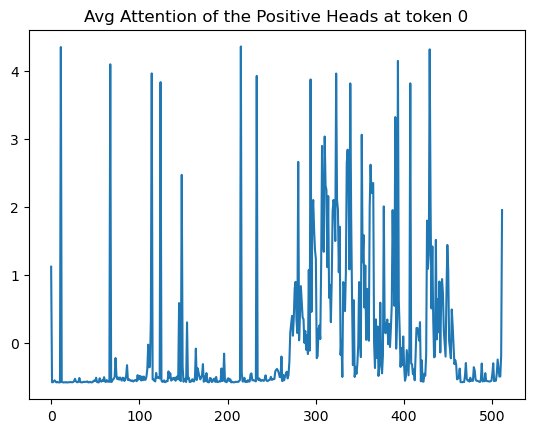

In [674]:
avg_att_m = np.zeros((512))
positives = [(11, 4), (11, 5), (11, 6), (11, 7), (11, 8)]
for level, h in positives:
    att_m = raw_att_probs[level, h, POS, :]
    avg_att_m += att_m
    
avg_att_m /= len(positives)
Z = (avg_att_m - np.mean(avg_att_m)) / np.std(avg_att_m)
#print(avg_att_m.shape)
plt.plot(Z)
plt.title(f"Avg Attention of the Positive Heads at token {POS}")
#plt.grid(True)
#plt.show()

positive_tokens = np.where(Z > 0)

In [675]:
h_to_logits_identified_pos = positive_tokens[0]

formatted = []
for i in range(512):
    t = tokenizer.decode(encoding['input_ids'][:, i])
    if i in h_to_logits_identified_pos:
        formatted.append('\033[103m ' + t + "\033[49m")
    else:
        formatted.append(t)

print(" ".join(formatted))

 [CLS] syn ##op ##tic comment for prostate tumors 1 . type  of tumor : pro ##static aden ##oca ##rc ##ino ##ma . " 2 . location of tumor : right apex ( slide e ##1 ) right lobe ( slides " " e ##3 - e ##5 ) left apex ( slide e ##2 ) and left lobe ( slides " e ##7 - e ##9 )  . 3 . estimated volume of tumor : 1 . 42 ml . 4 . g ##lea ##son score : 3 + 4 = 7 . 5 . estimated volume > g ##lea ##son pattern 3 : 15 % 6 . involvement of capsule : into capsule  . 7 . extra ##pro ##static extension : not present  . 8 . status of ex ##cision margins for tumor : tumor at ink ##ed sp ##ei ##cm ##en margin ( slide e ##1  ) ; see additional comment below . status of ex ##cision margins for benign prostate glands : benign glands present at ink ##ed margin . 9 . involvement of seminal ve ##sic ##le : free of tumor . 10 . per ##ine ##ural in ##filtration : present ( slide e ##9 ) . " 11 . pro ##static intra ##ep ##ith ##elial neo ##pl ##asia ( pin  ) : present ( slides e ##3 e ##4 e ##7 " " e ##8 e ##10 )

In [656]:
import matplotlib
import matplotlib.pyplot as plt

def colorize(words, color_array):
    cmap=matplotlib.cm.Blues
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

words = []
for i in range(len(encoding['input_ids'][0])):
    words.append(tokenizer.decode(encoding['input_ids'][:, i]))
s = colorize(words, avg_att_m)
# or simply save in an html file and open in browser
with open('colorize.html', 'w') as f:
    f.write(s)

In [349]:
positive_tokens

(array([133, 236, 237, 280, 329, 338, 389]),)

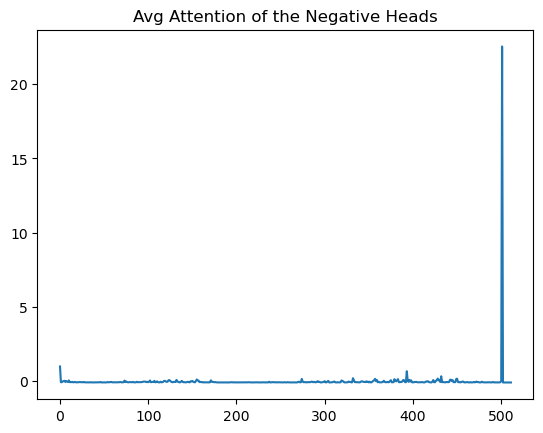

In [842]:
avg_att_m = np.zeros((512))
for level, h in negatives:
    att_m = raw_att_probs[level, h, POS, :]
    avg_att_m += att_m
    
avg_att_m /= len(negatives)
#plt.plot(avg_att_m)
Z = (avg_att_m - np.mean(avg_att_m)) / np.std(avg_att_m)
plt.plot(Z)
#s = sns.heatmap(avg_att_m, cmap="Blues")
#s.set(xlabel='Pos', ylabel='Pos')
plt.title(f"Avg Attention of the Negative Heads")
#plt.grid(True)
#plt.show()

negative_tokens = np.where(Z > 2)

In [843]:
negative_tokens

(array([501]),)

## Text highlight

In [844]:
#encoding['input_ids'].shape

In [845]:
#tokenizer.decode(encoding['input_ids'][:, 60])

In [477]:
h_to_logits_identified_pos = positive_tokens[0]

formatted = []
for i in range(512):
    t = tokenizer.decode(encoding['input_ids'][:, i])
    if i in h_to_logits_identified_pos:
        formatted.append('\033[103m ' + t + "\033[49m")
    else:
        formatted.append(t)

print(" ".join(formatted))

[CLS] syn ##op ##tic comment for prostate tumors null - type of tumor : small ac ##ina ##r aden ##oca ##rc ##ino ##ma . - location of tumor : left posterior mid  gland ( slides d ##17 and d ##18 ) . - estimated volume of  tumor : 0 . 3 cm ##3 . - g ##lea ##son  score : 4  + 3 . - estimated volume > g ##lea ##son pattern 3 : 70 % . - involvement of capsule : tumor invade ##s capsule in left posterior mid section  slide d ##18 . - extra ##pro ##static extension : none . - margin status for tumor : - negative . - margin status for benign prostate glands : - no benign glands present at ink ##ed ex ##cision margins . - high - grade pro ##static intra ##ep ##ith ##elial neo ##pl ##asia ( h ##gp ##in ) : present extensively . - tumor involvement of seminal ve ##sic ##le : none . - per ##ine ##ural in ##filtration : present ( slides d ##17 and d ##18 ) . - l ##ym ##ph node status : - negative ; total number of  nodes examined : 15 ( parts b and c ) . - aj ##cc / ui ##cc stage : pt ##2 ##an ##0

In [847]:
h_to_logits_identified_neg = negative_tokens[0]

formatted = []
for i in range(512):
    t = tokenizer.decode(encoding['input_ids'][:, i])
    if i in h_to_logits_identified_neg:
        formatted.append('\033[103m ' + t + "\033[49m")
    else:
        formatted.append(t)

print(" ".join(formatted))

[CLS] syn ##op ##tic comment for prostate tumors 1 . type of tumor : small ac ##ina ##r aden ##oca ##rc ##ino ##ma . " 2 . location of tumor : right anterior mid gland slide a1 ##1 ; right posterior " " mid ##gl ##and slides a2 a1 ##3 and a1 ##4 . " 3 . estimated volume of tumor : 2 . 6 cubic cm . 4 . g ##lea ##son score : 4 + 3 . 5 . estimated volume > g ##lea ##son pattern 3 : 2 cubic cm . 6 . involvement of capsule : tumor invade ##s capsule of right posterior " mid gland slides a2 a1 ##3 and a1 ##4 . " 7 . extra ##pro ##static extension : no extra ##pro ##static extension . 8 . status of ex ##cision margins for tumor : no tumor at ink ##ed inc ##ision margins . status of ex ##cision margins for benign prostate glands : no benign glands present at ink ##ed ex ##cision margins . " 9 . involvement of seminal ve ##sic ##le : present right side outer wall ( slide " a2 ##3 ) . 10 . per ##ine ##ural in ##filtration : present . 11 . pro ##static intra ##ep ##ith ##elial neo ##pl ##asia ( p

In [299]:
h_to_logits_identified_nodes = [(11, 0), (11, 9), (11, 4), (10, 3), (11, 7), (11, 11), (10, 7)]
avg_att_m = np.zeros((512, 512))
for level, h in h_to_logits_identified_nodes:
    att_m = np_att_probs[level, h, :, :]
    avg_att_m += att_m
    
avg_att_m /= len(h_to_logits_identified_nodes)
s = sns.heatmap(avg_att_m, cmap="Blues")
s.set(xlabel='Pos', ylabel='Pos')
plt.title(f"Avg Attention Prob of the Identified Heads")
plt.grid(True)
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_132017/146137947.py:3 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_132017/146137947.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: cannot unpack non-iterable numpy.int64 object

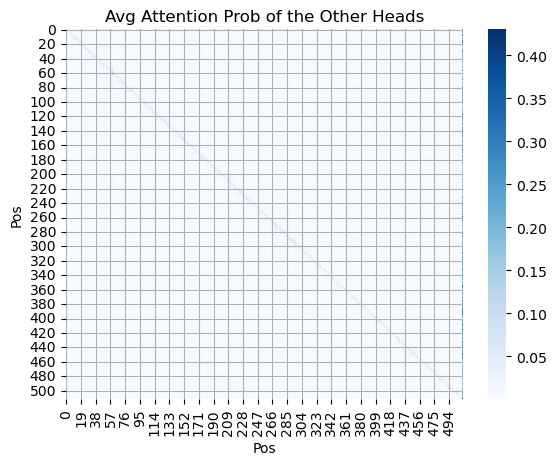

p_pg avg in the others:  0.009446654314278387
p_pg avg in the identified:  0.030796139104103455
% more focused on the pg pos:  2.2600048736361447


In [202]:
# the attn prob comparison of the identified heads with the other heads / average
# primary gleason pos = 60

other_att_m = np.zeros((512, 512))
for level in range(12):
    for h in range(12):
        if (level, h) not in h_to_logits_identified_nodes:
            att_m = np_att_probs[level, h, :, :]
            other_att_m += att_m

other_att_m /= (12*12 - len(h_to_logits_identified_nodes))
s = sns.heatmap(other_att_m, cmap="Blues")
s.set(xlabel='Pos', ylabel='Pos')
plt.title(f"Avg Attention Prob of the Other Heads")
plt.grid(True)
plt.show()

print('p_pg avg in the others: ', np.mean(other_att_m[:, 60]))
print('p_pg avg in the identified: ', np.mean(avg_att_m[:, 60]))
print('% more focused on the pg pos: ', (np.mean(avg_att_m[:, 60]) - np.mean(other_att_m[:, 60])) / (np.mean(other_att_m[:, 60])))

## h to logits: N = 200 experiment

In [40]:
N = 200
enc_lst = []
for text in documents_full[:N]:
    encoding = get_encoding(text, tokenizer)
    enc_lst.append(encoding)

In [ ]:
# path patching exp ALGO: direct effect on logits
# h -> logits
perc_lst = []
raw_att_probs_lst = []
for i in range(N):
    h_ctbn_tot = patch_h_to_logits(enc_lst[i], ft_model)
    perc, raw_att_probs = compute_logit_change_h_to_logits(enc_lst[i], ft_model, h_ctbn_tot)
    perc_lst.append(perc)
    raw_att_probs_lst.append(raw_att_probs)
    print(f"{i}-doc done")

#plot_h_to_logits_perc_change(perc)

In [42]:
import pickle

np_perc_200 = np.stack(perc_lst)
np_att_probs_200 = np.stack(raw_att_probs_lst)

h_to_logits_path = f"{base_dir}/new_output/patching/{args['model_type']}/h_to_logits"
os.makedirs(h_to_logits_path, exist_ok=True)

with open(os.path.join(h_to_logits_path, "rel_diff_perc_200.pkl"), 'wb') as handle:
    pickle.dump(np_perc_200, handle)

with open(os.path.join(h_to_logits_path, "att_probs_200.pkl"), 'wb') as handle:
    pickle.dump(np_att_probs_200, handle)
    
with open(os.path.join(h_to_logits_path, "rel_diff_perc_200.pkl"), 'rb') as handle:
    get_back_perc = pickle.load(handle) # [N, level, head] -> [200, 12, 12]
    
with open(os.path.join(h_to_logits_path, "att_probs_200.pkl"), 'rb') as handle:
    get_back_att_probs = pickle.load(handle) # [N, level, head, 512, 512] -> [200, 12, 12, 512, 512]

MemoryError: 

In [ ]:
h_to_logits_path = f"{base_dir}/new_output/patching/{args['model_type']}/h_to_logits"
os.makedirs(h_to_logits_path, exist_ok=True)

with open(os.path.join(h_to_logits_path, "rel_diff_perc_200.pkl"), 'wb') as handle:
    pickle.dump(np_perc_200, handle)
    
with open(os.path.join(h_to_logits_path, "att_probs_200_trunc.pkl"), 'wb') as handle:
    pickle.dump(np_att_probs_200[:15], handle)

In [43]:
np_att_probs_200.shape

(200, 12, 12, 512, 512)

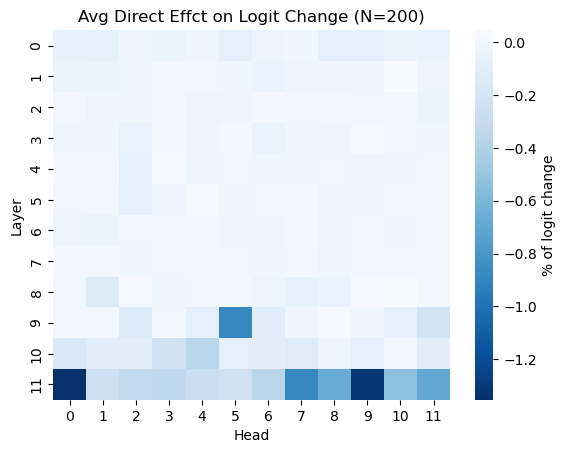

In [47]:
avg_perc_200 = np.mean(np_perc_200, axis=0)

plt.figure()
s = sns.heatmap(avg_perc_200, xticklabels = range(12), yticklabels = range(12), cmap="Blues_r",
            cbar_kws={'label': '% of logit change'})
s.set(xlabel='Head', ylabel='Layer')
plt.title("Avg Direct Effct on Logit Change (N=200)")
#plt.show()
plt.savefig(os.path.join(h_to_logits_path, f'avg_direct_effect_on_logit_change.png'), bbox_inches='tight')

Positively contributing nodes: 11.0, 11.9, 11.7, 9.5, 11.8, 11.11, 11.10 

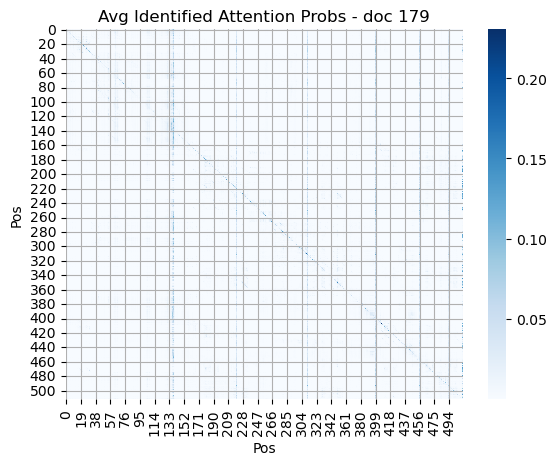

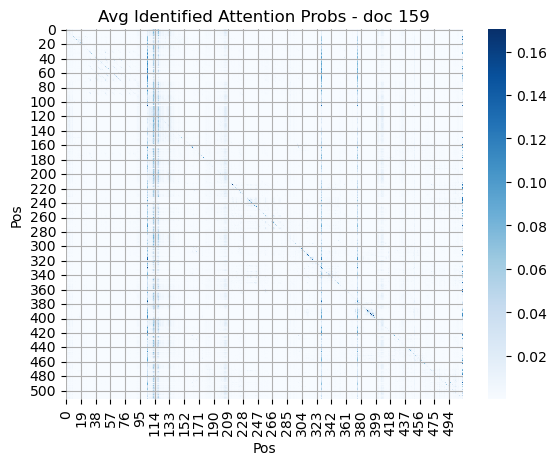

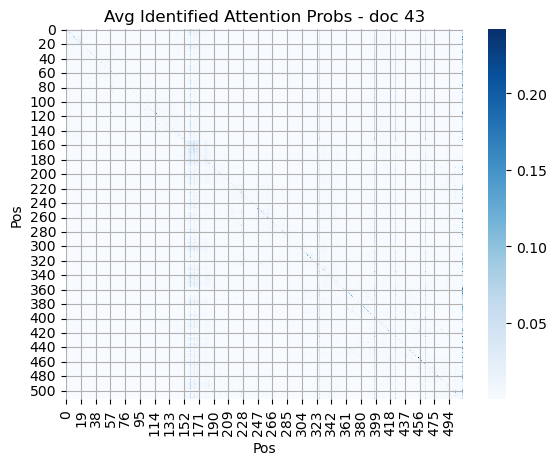

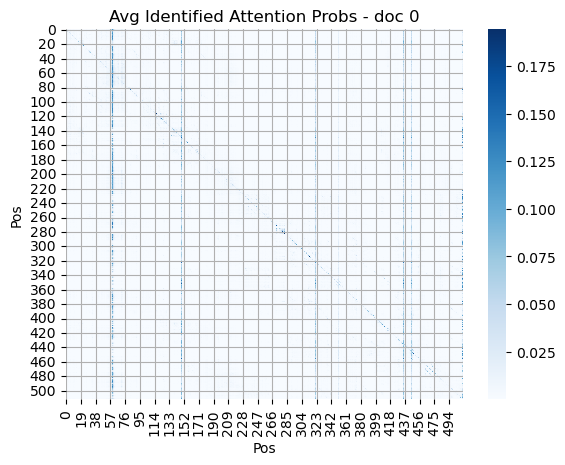

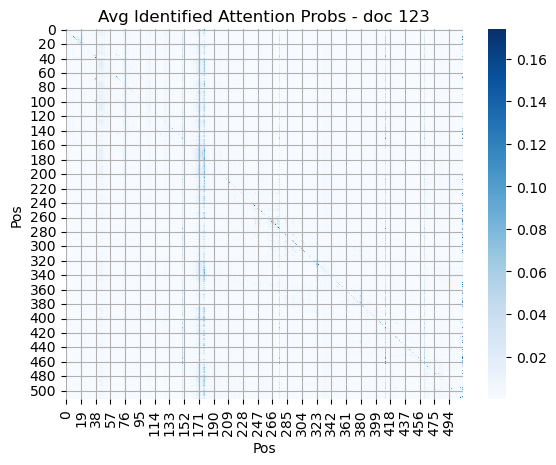

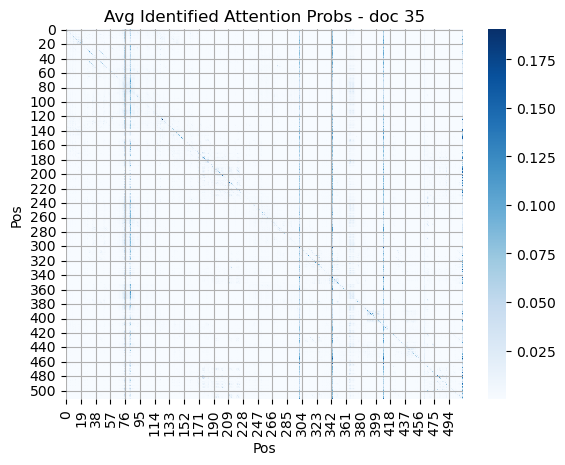

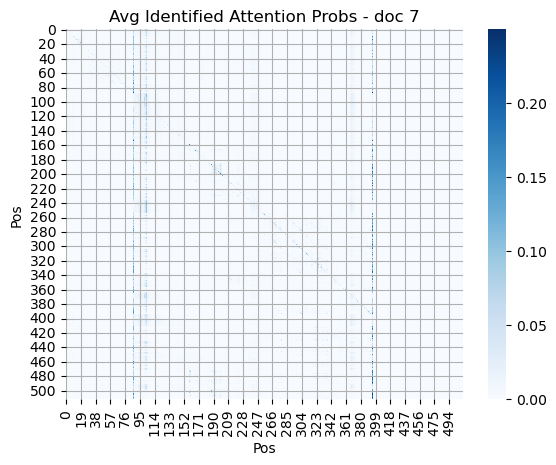

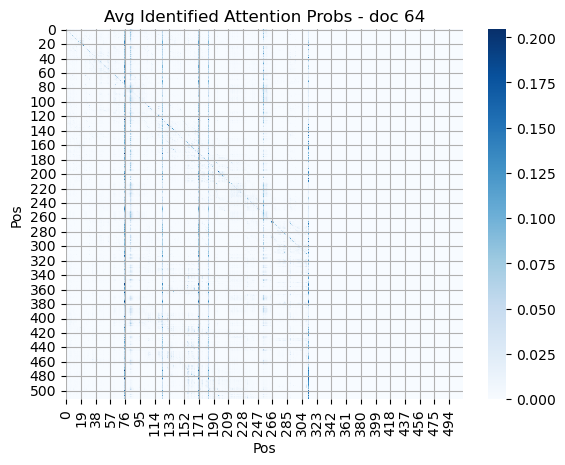

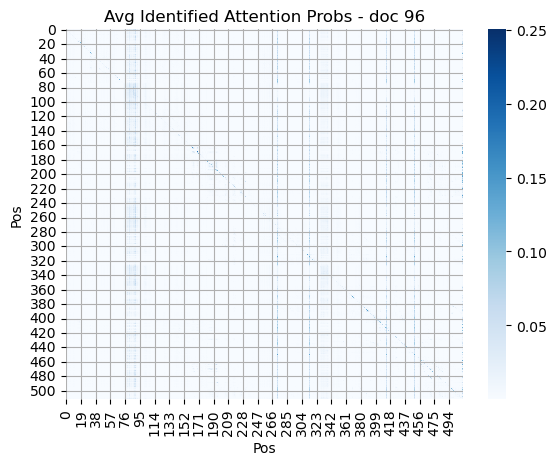

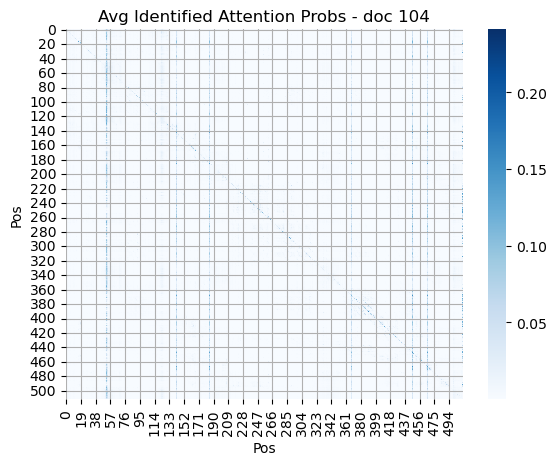

In [87]:
h_to_logits_identified_nodes_N200 = [(11, 0), (11, 9), (11, 7), (9, 5), (11, 8), (11, 11), (11, 10)]

#for i in range(5):
#idx = random.choice(range(200))
for idx in [179, 159, 43, 0, 123, 35, 7, 64, 96, 104]:
    plt.figure()
    att_probs_rand = np_att_probs_200[idx]

    att_m = np.zeros((512, 512))
    for level, h in h_to_logits_identified_nodes_N200:
        att_m += att_probs_rand[level, h, :, :]

    s = sns.heatmap(att_m / len(h_to_logits_identified_nodes_N200), cmap="Blues")
    s.set(xlabel='Pos', ylabel='Pos')
    plt.title(f"Avg Identified Attention Probs - doc {idx}")
    plt.grid(True)
    plt.savefig(os.path.join(h_to_logits_path, f'avg_identified_att_probs_doc_{idx}.png'), bbox_inches='tight')
    #plt.show()

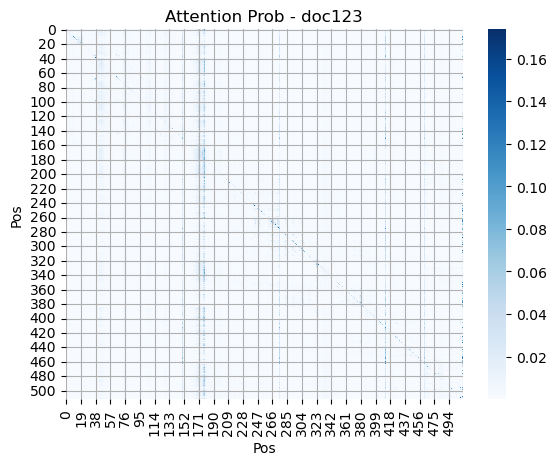

In [99]:
idx=123
#pos = [152, 160, 166, 327, 335, 398, 425, 463]
att_probs_rand = np_att_probs_200[idx]

att_m = np.zeros((512, 512))
for level, h in h_to_logits_identified_nodes_N200:
    att_m += att_probs_rand[level, h, :, :]

s = sns.heatmap(att_m[:, :] / len(h_to_logits_identified_nodes_N200), cmap="Blues")
s.set(xlabel='Pos', ylabel='Pos')
plt.title(f"Attention Prob - doc{idx}")
plt.grid(True)
plt.show()

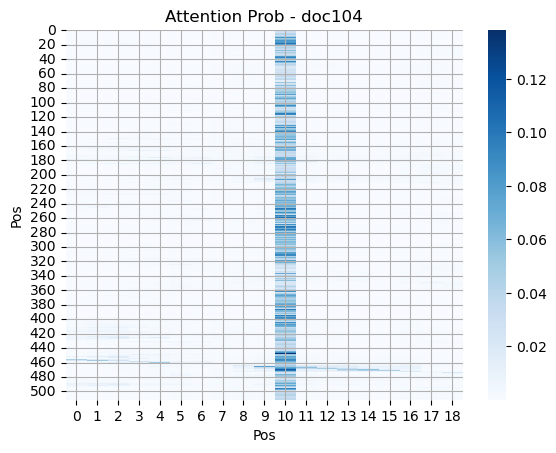

In [86]:
idx=104
#pos = [52, 53, 123, 142, 185, 368, 447, 466]
att_probs_rand = np_att_probs_200[idx]

att_m = np.zeros((512, 512))
for level, h in h_to_logits_identified_nodes_N200:
    att_m += att_probs_rand[level, h, :, :]

s = sns.heatmap(att_m[:, 456:475] / len(h_to_logits_identified_nodes_N200), cmap="Blues")
s.set(xlabel='Pos', ylabel='Pos')
plt.title(f"Attention Prob - doc{idx}")
plt.grid(True)
plt.show()

In [100]:
HL_doc_pos = {179:[63, 66, 105, 107, 137, 138, 220, 311, 399, 456],
              159:[105, 113, 114, 117, 119, 329, 376],
              43:[160, 166, 327, 335, 398, 425, 463],
              0:[60, 149, 322, 351, 435, 445],
              123:[150, 170, 171, 176, 178, 275, 412, 459, 462],
              35:[75, 82, 83, 301, 343, 409],
              7:[87, 95, 96, 101, 102, 103, 395],
              64:[75, 83, 124, 171, 183, 253, 313],
              96:[79, 81, 82, 87, 88, 89, 273, 314, 413, 449, 450],
              104:[52, 53, 142, 185, 368, 447, 466]
              }

save_doc = {}
for doc_id, pos_lst in HL_doc_pos.items():
    label = labels_full[doc_id]
    print("document id: ", doc_id)
    print("groundtruth label: ", label)
    text = documents_full[doc_id]
    encoding = get_encoding(text, tokenizer)
    highlighted = print_highlight_text(encoding, pos_lst)
    save_doc[doc_id] = highlighted
    print("="*50)

with open(os.path.join(h_to_logits_path, "highlighted_samples.pkl"), 'wb') as handle:
    pickle.dump(save_doc, handle)

document id:  179
groundtruth label:  4
[CLS] syn ##op ##tic comment for prostate tumors - type of tumor : small ac ##ina ##r aden ##oca ##rc ##ino ##ma and pro ##static duct ##al aden ##oca ##rc ##ino ##ma . - location of tumor : highest grade nod ##ule : right apex ( slides e ##1 - 2 e ##12 ) ~ 1 . 5 cc g ##lea ##son score  4 + 4  = 8 . approximately four additional tumor nod ##ules are seen in the bilateral apex mid ##gl ##and and base ( slides e ##3 e ##12 - 18 ) ~ 5 cc in aggregate g ##lea ##son score 3  + 4  = 7 . - estimated total volume of tumor : ~ 6 . 5 cc . - overall g ##lea ##son score : 4 + 3 = 7 ; primary  pattern  4 secondary pattern 3 . - estimated volume > g ##lea ##son pattern 3 : 50 % . - involvement of capsule : none . - extra ##pro ##static extension : none definitive ##ly identified . several glands are present within loose connect ##ive tissue st ##rom ##a in the right apex raising suspicion for extra ##pro ##static extension . however the boundary of the prostat

In [12]:
import pickle
h_to_logits_path = f"{base_dir}/new_output/patching/{args['model_type']}/h_to_logits"
with open(os.path.join(h_to_logits_path, "highlighted_samples.pkl"), 'rb') as handle:
    get_back_text = pickle.load(handle)
print(str(get_back_text[7]))

[CLS] syn ##op ##tic comment for prostate tumors - type of tumor : small ac ##ina ##r aden ##oca ##rc ##ino ##ma . - location of tumor : right apex ( slide d ##1 ) ; central apex ( slide d ##2 ) ; right anterior quadrant ( slide d ##4 ) ; right posterior quadrant ( slides d ##7 and d ##9 ) ; left anterior quadrant ( slides d ##13 and d ##15 ) . - estimated volume of tumor : 0 . 5 ml  . " - g ##lea ##son score :  3  + 3 = 6 ;  primary  pattern  3 secondary pattern 3 . " - estimated volume > g ##lea ##son pattern 3 : 0 % . - involvement of capsule : none . - extra ##pro ##static extension : none . - margin status for tumor : - negative but close focal ##ly ( slide d ##4 ) . - margin status for benign prostate glands : " - benign glands present at ink ##ed ex ##cision margins central apex ( slide " d ##2 ) . " - high - grade pro ##static intra ##ep ##ith ##elial neo ##pl ##asia ( h ##gp ##in ) : present " extensively . - tumor involvement of seminal ve ##sic ##le : none . - per ##ine ##ur

In [105]:
PG_doc_pos = {179:63, 159:113, 43:160, 0:60, 123:170, 35:75, 7:95, 64:83, 96:81, 104:52}

In [107]:
pg_prob_others = []
pg_prob_identified = []
focus_perc = []

for doc_id, pg_pos in PG_doc_pos.items():
    att_probs = np_att_probs_200[doc_id]

    att_m = np.zeros((512, 512))
    other_att_m = np.zeros((512, 512))
   
    for level in range(12):
        for h in range(12):
            if (level, h) not in h_to_logits_identified_nodes_N200:
                other_att_m += att_probs[level, h, :, :]
            else:
                att_m += att_probs[level, h, :, :]

    other_att_m /= (12*12 - len(h_to_logits_identified_nodes_N200))
    att_m /= len(h_to_logits_identified_nodes_N200)
    other_mean_prob = np.mean(other_att_m[:, pg_pos])
    identified_mean_prob = np.mean(att_m[:, pg_pos])
    
    improv_perc = (identified_mean_prob - other_mean_prob) / other_mean_prob * 100
    
    pg_prob_others.append(other_mean_prob)
    pg_prob_identified.append(identified_mean_prob)
    focus_perc.append(improv_perc)

print('p_pg avg in the others (# sample=10): ', np.mean(pg_prob_others), ' std: ', np.std(pg_prob_others))
print('p_pg avg in the identified (# sample=10): ', np.mean(pg_prob_identified), 'std: ', np.std(pg_prob_identified))
print('% more focused on the pg pos (# sample=10): ', np.mean(focus_perc), 'std: ', np.std(focus_perc))

p_pg avg in the others (# sample=10):  0.00576280201919513  std:  0.0009123918063505562
p_pg avg in the identified (# sample=10):  0.041095768749498586 std:  0.0180868169945076
% more focused on the pg pos (# sample=10):  586.1854131354847 std:  247.94551791343116


In [108]:
focus_perc

[85.99960428965132,
 564.0952507239936,
 617.6239590833138,
 983.6142494740354,
 549.9492622929203,
 600.9181421343492,
 363.62898829879924,
 588.0877944785824,
 532.8456959390461,
 975.0911846401568]

In [109]:
pg_prob_others

[0.003698448427524142,
 0.006397058695441264,
 0.00623838895180104,
 0.007092992031019011,
 0.005978617308921987,
 0.004754581514346306,
 0.005922651177812808,
 0.005273604923114054,
 0.006307447833737231,
 0.005964229328233456]

In [110]:
pg_prob_identified

[0.006879099440051736,
 0.0424825629824517,
 0.044768173778930664,
 0.0768606723621798,
 0.0388579790946553,
 0.03332572441661933,
 0.027459127736160438,
 0.036287031804969436,
 0.039916412139406665,
 0.06412090373956073]

In [ ]:
# TO-DO: look at h-to-logits for the 3 clusters

In [240]:
np.stack(perc_lst).shape

(200, 12, 12)

In [241]:
np.stack(raw_att_probs_lst).shape

(200, 12, 12, 512, 512)

In [ ]:
# path patching exp ALGO:
# h -> R
# update receiver nodes (R) iteratively
for h in range(12):
    patched_entry = [(11, 0, h)]
    rel, irrel = prop_classifier_model_patched(encoding, ft_model, patched_entry)
    

In [887]:
# Get raw output

#raw_logit = ft_model(**encoding, output_hidden_states = False)
raw_logit = model(**encoding)[0]
le_dict[labels_full[0]]

1

In [888]:
raw_logit

tensor([[ 6.2439, -2.5307, -3.2723]], device='cuda:0')

In [792]:
rel_raw, irrel_raw, _ = prop_classifier_model_patched(encoding, model, [])

In [793]:
rel_raw

tensor([[0., 0., 0.]], device='cuda:0')

In [794]:
irrel_raw

tensor([[ 6.2078, -2.2949, -3.5347]], device='cuda:0')

In [967]:
patched_entries_1 = [(i, i, i) for i in range(12)]
patched_entries_2 = [(j, 0, i) for i in range(12) for j in [7, 8, 9, 10]]
patched_entries_3 = [(0, 0, i) for i in range(12)]

In [968]:
rel_2, irrel_2, _ = prop_classifier_model_patched(encoding, model, patched_entries_2)

In [969]:
rel_2 + irrel_2

tensor([[ 6.1108, -2.0876, -3.5848]], device='cuda:0')

In [970]:
rel_2

tensor([[ 1.9962, -1.0597, -0.8254]], device='cuda:0')

In [971]:
irrel_2

tensor([[ 4.1146, -1.0280, -2.7594]], device='cuda:0')

In [938]:
rel_3, irrel_3, _ = prop_classifier_model_patched(encoding, model, patched_entries_3)

In [939]:
rel_3

tensor([[ 2.0988, -0.8599, -1.1609]], device='cuda:0')

In [940]:
irrel_3

tensor([[ 4.1451, -1.6707, -2.1114]], device='cuda:0')

In [ ]:
11.0, 11.9, 11.7, 9.5, 11.8, 11.11, 11.10

In [208]:
rel_5, irrel_5, _ = prop_classifier_model_patched(encoding, ft_model, [(11, 0, 0), (11, 0, 9), (11, 0, 7), (9, 0, 5), (11, 0, 8), (11, 0, 11), (11, 0, 10)])

torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])


In [209]:
rel_5 + irrel_5

tensor([[-2.7155, -1.7594,  7.6671, -0.9557, -2.2298]], device='cuda:1')

In [210]:
rel_5

tensor([[-2.7155, -1.7594,  7.6671, -0.9557, -2.2298]], device='cuda:1')

In [211]:
irrel_5

tensor([[0., 0., 0., 0., 0.]], device='cuda:1')

In [212]:
(7.6671 - 8.3976) / 8.3976 * 100

-8.698913975421561

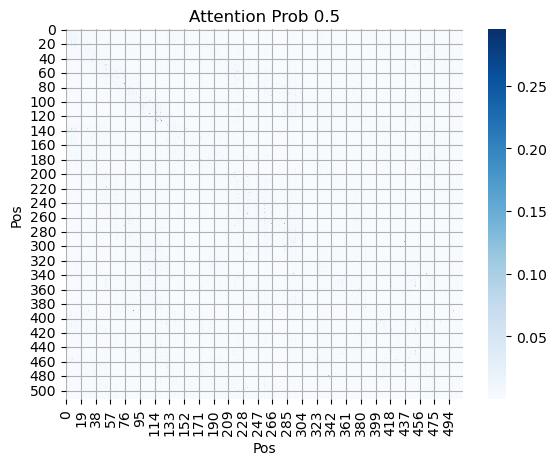

In [193]:
plot_identified_heads_att_matrix(raw_att_probs, [(0,5)])

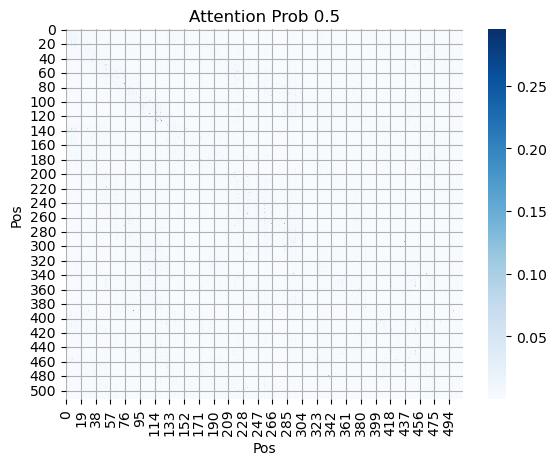

In [194]:
new_att_probs = torch.stack(new_attn).cpu().numpy()
plot_identified_heads_att_matrix(new_att_probs, [(0,5)])

In [188]:
new_attn

[]

In [76]:
rel_1, irrel_1, _ = prop_classifier_model_patched(encoding, ft_model, patched_entries_1)

In [77]:
rel_1 + irrel_1

tensor([[-2.0533, -1.8698,  8.3976, -1.9867, -2.0811]], device='cuda:1')

In [78]:
rel_1

tensor([[-1.4871, -1.6352,  6.6170, -1.6021, -1.5689]], device='cuda:1')

In [104]:
(8.39 - 8.22 )/8.39

0.0202622169249106

In [79]:
irrel_1

tensor([[-0.5662, -0.2346,  1.7805, -0.3846, -0.5122]], device='cuda:1')

## sanity checks:
- irrel_out should always be zero at the output.
- rel_out < raw_rel when ablating important nodes.
- rel_out == raw_rel when ablating nodes that don't matter to the prediction.
*so far we are observing the change in classification logits when ablating source nodes.
Namely, the direct effect on source heads (target to idetify) -> logits.

## to-do:
Next, we want to observe the direct effect on source heads (target to identify) -> receiver heads (identified in the previous round).
So that we can construct a circuit.
(back tracking)
- collect cd scores of receiver nodes when ablating source nodes.
After having a complete circuit, we want to compare the performance using this circuit with that using the full model. Does the performance drop (significantly or minorly?)?